
# Практика 03. Embedding

In [1]:
import os
import numpy as np
import random

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline


np.random.seed(0)
random.seed(0)

## Модели эмбеддингов на основе предсказаний

Мы будем пользоваться библиотекой [gensim](https://radimrehurek.com/gensim/models/word2vec.html), так как в ней удобно реализованы различные методы обучения эмбеддингов: `word2vec`, `glove` и другие.

Кроме того, существуют уже предобученные модели, что позволяет в несколько строк получить качественные эмбеддинги. Посмотрим на список доступных моделей ниже.

In [3]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 45.8 MB/s eta 0:00:00


In [4]:
import gensim
import gensim.downloader

In [5]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Для наглядности мы будем использвовать `word2vec-ruscorpora-300`, так как это обученные эмбеддинги для русского языка.

In [6]:
word2vec_rus = gensim.downloader.load('word2vec-ruscorpora-300')

[==================================================] 100.0% 198.8/198.8MB downloaded


In [7]:
print(f"Всего слов {len(word2vec_rus.index_to_key)}")
print(f"Размерность {word2vec_rus.vector_size}")

print(f"Примеры слов:", ', '.join(word2vec_rus.index_to_key[:10]))


Всего слов 184973
Размерность 300
Примеры слов: весь_DET, человек_NOUN, мочь_VERB, год_NOUN, сказать_VERB, время_NOUN, говорить_VERB, становиться_VERB, знать_VERB, самый_DET


Можно заметить, что каждое слово имеет суффикс, который отвечает за часть речи (NOUN - существительное, VERB - глагол и тд). Задача определения части речи называется `Part of speach tagging`.

Красивую визуализацию можно найти [тут](https://rusvectores.org/ru/visual/).

Мы же попробуем визуализировать и изучить интересные свойства самостоятельно.

### Визуализация

Мы знаем, что похожие по смыслу слова должны иметь похожие по метрике эмбеддинги. Для визуализации (понижения размерности) будем пользоваться метод UMAP ([UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction](https://arxiv.org/abs/1802.03426)), который реализован в библиотеке [umap](https://umap-learn.readthedocs.io/en/latest/).

In [8]:
!pip install umap-learn

In [9]:
import umap

Выделим, специальные слова, за которыми будем следить. Постараемся выбрать слова из разных категорий.

In [10]:
embeddings = word2vec_rus.vectors

spec_key = [
    'москва', 'город', 'берлин', 'страна',    # география
    'яблоко', 'груша', 'апельсин', 'помидор', # овощи и фрукты
    'рабочий', 'строитель', 'водитель',       # специальности
    'парикмахерская', 'барбер', 'цирюльник'   # что-то с волосами
]

spec_emb  = np.array(list(word2vec_rus.get_vector(k + "_NOUN") for k in spec_key))
spec_emb.shape

(14, 300)

Посмотрим как расположены выделенные нами слова друг относительно друга.

In [11]:
mapper = umap.UMAP(n_components=2, n_neighbors=6, metric='cosine')

u_spec = mapper.fit_transform(spec_emb)

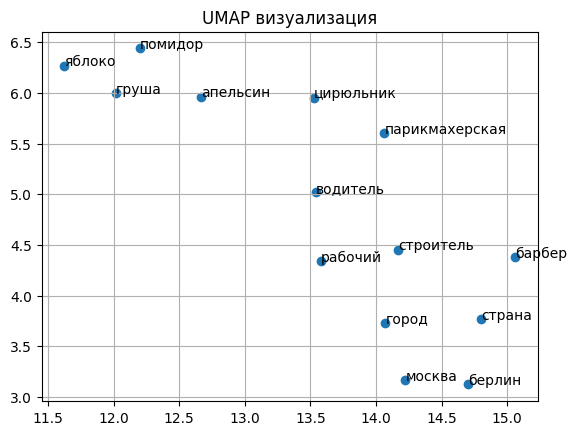

In [12]:
plt.scatter(u_spec[:,0], u_spec[:,1])

for i, txt in enumerate(spec_key):
    plt.annotate(txt, (u_spec[i, 0], u_spec[i, 1]))
plt.title('UMAP визуализация')
plt.grid()

Посмотрим как расположены выделенные нами слова на общем множестве.

In [13]:
mapper = umap.UMAP(n_components=2, metric='cosine')

u      = mapper.fit_transform(embeddings[:10_000])
u_spec = mapper.transform(spec_emb)

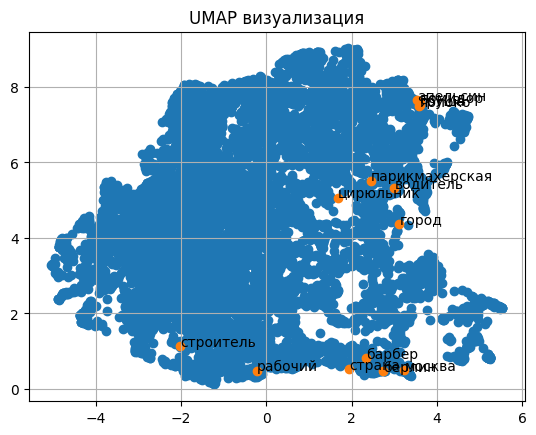

In [14]:
plt.scatter(u[:,0], u[:,1])
plt.scatter(u_spec[:,0], u_spec[:,1])

for i, txt in enumerate(spec_key):
    plt.annotate(txt, (u_spec[i, 0], u_spec[i, 1]))
plt.title('UMAP визуализация')
plt.grid()

## Операции над эмбеддингами

В моделях из библиотеки `gensim` реализован автоматический поиск наиболее похожих слов, то есть поиск слов, чьи эмбеддинги наиболее близки.

In [15]:
a = word2vec_rus.get_vector('холод_NOUN')

word2vec_rus.similar_by_vector(a)

[('холод_NOUN', 1.0),
 ('стужа_NOUN', 0.754147469997406),
 ('мороз_NOUN', 0.7195620536804199),
 ('сырость_NOUN', 0.6915026307106018),
 ('мерзнуть_VERB', 0.6622565984725952),
 ('тепло_NOUN', 0.6225268840789795),
 ('зябнуть_VERB', 0.6161022186279297),
 ('жара_NOUN', 0.6121419668197632),
 ('замерзать_VERB', 0.6117622256278992),
 ('знобить_VERB', 0.5948620438575745)]

Кроме того, мы можем производить над эмбеддингами арифметические операции.

In [16]:
a = word2vec_rus.get_vector('король_NOUN')
b = word2vec_rus.get_vector('мужчина_NOUN')

word2vec_rus.similar_by_vector(a - b)

[('король_NOUN', 0.6571975350379944),
 ('королевство_NOUN', 0.45206212997436523),
 ('королевский_ADJ', 0.4399426579475403),
 ('максимилианов_NOUN', 0.421102374792099),
 ('кельский_ADJ', 0.41280296444892883),
 ('каролус_NOUN', 0.4126133322715759),
 ('рагоци_NOUN', 0.40673765540122986),
 ('герцог_NOUN', 0.4043634831905365),
 ('королева_NOUN', 0.40316253900527954),
 ('дурлахский_ADJ', 0.4029974937438965)]

In [17]:
c = word2vec_rus.get_vector('женщина_NOUN')

word2vec_rus.similar_by_vector(a - b + c)

[('король_NOUN', 0.8805387616157532),
 ('королева_NOUN', 0.7313904762268066),
 ('герцог_NOUN', 0.6502388715744019),
 ('принцесса_NOUN', 0.6266285181045532),
 ('герцогиня_NOUN', 0.6240381598472595),
 ('королевство_NOUN', 0.6094207167625427),
 ('зюдерманландский_ADJ', 0.6084389686584473),
 ('дурлахский_ADJ', 0.6081665754318237),
 ('ульрик::элеонора_NOUN', 0.6073107719421387),
 ('максимилианов_NOUN', 0.6057003736495972)]

In [18]:
a = word2vec_rus.get_vector('москва_NOUN')
b = word2vec_rus.get_vector('россия_NOUN')
c = word2vec_rus.get_vector('германия_NOUN')

word2vec_rus.similar_by_vector(a - b + c)

[('берлин_NOUN', 0.7166863679885864),
 ('москва_NOUN', 0.6859816312789917),
 ('германия_NOUN', 0.6379823088645935),
 ('мюнхен_NOUN', 0.6141613721847534),
 ('гамбург_NOUN', 0.5910832285881042),
 ('дрезден_NOUN', 0.5751315951347351),
 ('бабельсберг_NOUN', 0.5680847764015198),
 ('париж_NOUN', 0.5643576979637146),
 ('лейпциг_NOUN', 0.555885910987854),
 ('карлсхорст_NOUN', 0.553295373916626)]

Чуть аккуратней этот функционал уже реализован в библиотеке.

In [19]:
word2vec_rus.most_similar(
    positive=['москва_NOUN', 'германия_NOUN'],
    negative=['россия_NOUN']
)

[('берлин_NOUN', 0.7166863679885864),
 ('мюнхен_NOUN', 0.6141614317893982),
 ('гамбург_NOUN', 0.5910831689834595),
 ('дрезден_NOUN', 0.5751316547393799),
 ('бабельсберг_NOUN', 0.5680848360061646),
 ('париж_NOUN', 0.5643577575683594),
 ('лейпциг_NOUN', 0.555885910987854),
 ('карлсхорст_NOUN', 0.5532953143119812),
 ('билефельд_NOUN', 0.5470366477966309),
 ('дуйсбург_NOUN', 0.5449016690254211)]

У некоторых слов много значений, поэтому мы найдем достаточно разные слова по смыслу.

In [20]:
word2vec_rus.similar_by_vector('ручка_NOUN')

[('ножка_NOUN', 0.6115206480026245),
 ('рукоятка_NOUN', 0.6041494607925415),
 ('рука_NOUN', 0.562088668346405),
 ('пальчик_NOUN', 0.5414899587631226),
 ('рычажок_NOUN', 0.5311201214790344),
 ('ноготочка_NOUN', 0.5253746509552002),
 ('головка_NOUN', 0.5234273076057434),
 ('дверной_ADJ', 0.5118672251701355),
 ('щечка_NOUN', 0.508470356464386),
 ('поприседать_VERB', 0.5080488324165344)]

Кроме того, можно быстро находить синонимы.

In [21]:
word2vec_rus.similar_by_vector('красивый_ADJ')

[('красиво_ADV', 0.6824069619178772),
 ('некрасивый_ADJ', 0.6662992238998413),
 ('нарядный_ADJ', 0.6605890989303589),
 ('прекрасный_ADJ', 0.6481409668922424),
 ('элегантный_ADJ', 0.6363735795021057),
 ('красавец_NOUN', 0.6171321868896484),
 ('очаровательный_ADJ', 0.6072524189949036),
 ('прелестный_ADJ', 0.606392502784729),
 ('хорошенький_ADJ', 0.6016284823417664),
 ('изящный_ADJ', 0.6009820699691772)]

Мы ожидаем, что для разных по смыслу словам расстояние между эмбеддингами будет больше, чем между похожими.

In [22]:
word2vec_rus.distance('лето_NOUN', 'тепло_NOUN')

np.float32(0.737251)

In [23]:
word2vec_rus.distance('лето_NOUN', 'весна_NOUN')

np.float32(0.23251086)

In [24]:
word2vec_rus.distance('лето_NOUN', 'осень_NOUN')

np.float32(0.19974983)

In [25]:
word2vec_rus.distance('лето_NOUN', 'зима_NOUN')

np.float32(0.18939573)

Однако не стоит забывать, что эмбеддинги не идеальные, поэтому иногда возникают странные ситуации.

In [26]:
word2vec_rus.distance('лето_NOUN', 'стол_NOUN')

np.float32(0.89319164)

In [27]:
word2vec_rus.distance('лето_NOUN', 'стул_NOUN')

np.float32(0.9371734)

В случае эмбеддингов полученных из нейронных сетей, можно даже обучать линейные модели для поиска "смысловых компонент" слова.

## Классификация

Мы хотим использовать векторные представления слов для алгоритмов машинного обучения или нейронных сетей. Прежде чем перейти к нейронным сетям, нам нужны бейзлайны, то есть то, с чем будем сравниваться. Сначала проверим, как работают стандартные алгоритмы машинного обучения на эмбеддингах.

Мы будем решать задачу бинарной классификации для [датасета рецензий с Imdb](https://ai.stanford.edu/~amaas/data/sentiment/).

В качестве базовой модели будем использовать [CatBoost](https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier).

Подробный список классических датасетов для классификации текста можно посмотреть [здесь](https://lena-voita.github.io/nlp_course/text_classification.html#dataset_examples)

In [28]:
if not os.path.exists("aclImdb_v1.tar.gz"):
    ! wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    ! tar -xvf aclImdb_v1.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclI

Мы не будем усердно заниматься предобработкой, так как наша цель -- сравнить методы, а не добиться более высокого качества. В качестве предобработки мы приведем все символы к нижнему регистру.

In [29]:
def preprocess(l):
    return l.lower()

In [30]:
def get_dataset(split='train', base_dir='aclImdb'):
    path_data   = os.path.join(base_dir, split)
    path_data_n = os.path.join(path_data, 'neg')
    path_data_p = os.path.join(path_data, 'pos')
    path_neg  = list(os.listdir(path_data_n))
    path_neg  = sorted(path_neg)
    path_pos  = list(os.listdir(path_data_p))
    path_pos  = sorted(path_pos)


    print(f"Объектов отрицательного класса {len(path_neg)}")
    print(f"Объектов положительного класса {len(path_pos)}")

    X = []
    y = [0] * len(path_neg) + [1] * len(path_pos)

    for p in path_neg:
        with open(os.path.join(path_data_n, p), 'r') as f:
            l = f.readline()
            X.append(preprocess(l))

    for p in path_pos:
        with open(os.path.join(path_data_p, p), 'r') as f:
            l = f.readline()
            X.append(preprocess(l))

    return X, y

In [31]:
X_train, y_train = get_dataset(split='train')

Объектов отрицательного класса 12500
Объектов положительного класса 12500


In [32]:
X_test, y_test = get_dataset(split='test')

Объектов отрицательного класса 12500
Объектов положительного класса 12500


Посмотрим на примеры предложений.

In [33]:
X_train[0]

"story of a man who has unnatural feelings for a pig. starts out with a opening scene that is a terrific example of absurd comedy. a formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting. even those from the era should be turned off. the cryptic dialogue would make shakespeare seem easy to a third grader. on a technical level it's better than you might think with some good cinematography by future great vilmos zsigmond. future stars sally kirkland and frederic forrest can be seen briefly."

In [34]:
X_test[0]

"once again mr. costner has dragged out a movie for far longer than necessary. aside from the terrific sea rescue sequences, of which there are very few i just did not care about any of the characters. most of us have ghosts in the closet, and costner's character are realized early on, and then forgotten until much later, by which time i did not care. the character we should really care about is a very cocky, overconfident ashton kutcher. the problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. his only obstacle appears to be winning over costner. finally when we are well past the half way point of this stinker, costner tells us all about kutcher's ghosts. we are told why kutcher is driven to be the best with no prior inkling or foreshadowing. no magic here, it was all i could do to keep from turning it off an hour in."

Для обучения моделей эмбедингов, нам нужно разделить слова на структурные единицы (символы, слова, N-Gramm). Мы будем работать на уровне слов.

In [35]:
def get_corpus(X_data):

    return list(x.split() for x in X_data)

In [36]:
corpus_train = get_corpus(X_train)
corpus_test  = get_corpus(X_test)

In [37]:
corpus_train[0][:10]

['story', 'of', 'a', 'man', 'who', 'has', 'unnatural', 'feelings', 'for', 'a']

### word2vec

Обучим word2vec модель на наших данных.

**Важно:** Мы обучаем модель на всем корпусе текста, так как нам нужно построить словарь. Кроме того, мы решаем задачу обучения без учителя.

In [38]:
main_corpus = corpus_train + corpus_test

In [39]:
%%time
model_wv = gensim.models.Word2Vec(sentences=main_corpus, vector_size=100, window=5, min_count=1, workers=4)

CPU times: user 3min 25s, sys: 1.3 s, total: 3min 26s
Wall time: 2min 13s


Эмбеддинг слова является вектором размерности 100, при этом каждое предложение имеет разную длину. Мы (пока) не умеем обучать модель на данных произвольного размера, поэтому нам нужно как-то аггрегировать эмбединги по всему предложению.

Мы будем использовать средний эмбеддинг предложения, как фичу для обучению классификатора. В таком подходе мы **не учитываем порядок слов**, то есть теряем много информации.

In [40]:
def encode_corpus(corpus, encode_fn):

    corp_enc = []
    for sentences in corpus:
        sent_enc = list(encode_fn(w) for w in sentences)
        sent_enc = np.array(sent_enc).mean(axis=0)

        corp_enc.append(sent_enc)

    return np.array(corp_enc)

In [41]:
enc_train_wv = encode_corpus(corpus_train, lambda k: model_wv.wv[k])
enc_test_wv  = encode_corpus(corpus_test,  lambda k: model_wv.wv[k])

In [43]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


In [44]:
from catboost import CatBoostClassifier

In [45]:
def accuracy(y_pred, y_test):
    acc = np.mean(y_pred == y_test)
    print(f"Точность {acc:0.3f}")

In [46]:
clf = CatBoostClassifier()
clf.fit(enc_train_wv, y_train, verbose=False)

In [47]:
y_pred = clf.predict(enc_test_wv)
accuracy(y_pred, y_test)

Точность 0.798


# fasttext

Для использования библиотеки `fasstext` будем использовать специализированную [библиотеку](https://fasttext.cc/docs/en/python-module.html). Для этого нам необходимо записать наш корпус текста в файл.

In [48]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498214 sha256=c956c1cf42e7354af4d8bbe3f08bf3c190342597a559f9bb25a36750d7bf254b
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


In [49]:
import fasttext

In [50]:
data = X_train + X_test
data = list(d + "\n" for d in data)

In [51]:
with open("all_data.txt", "w") as f:
    f.writelines(data)

In [52]:
# CPU times: user 53min 7s, sys: 5.48 s, total: 53min 12s

%%time
model_fasttext = fasttext.train_unsupervised(
    "all_data.txt",
    model='skipgram',
    dim=100,
    epoch=10,
    wordNgrams=2,
    verbose=1
)

CPU times: user 53min 7s, sys: 5.48 s, total: 53min 12s
Wall time: 53min 44s


In [53]:
model_fasttext.save_model("model_fasttext.bin")
# model_fasttext = fasttext.load_model("model_fasttext.bin")

In [54]:
enc_train_ft = encode_corpus(corpus_train, lambda k: model_fasttext[k])
enc_test_ft  = encode_corpus(corpus_test,  lambda k: model_fasttext[k])

In [55]:
clf = CatBoostClassifier()
clf.fit(enc_train_ft, y_train, verbose=False)

In [56]:
y_pred = clf.predict(enc_test_ft)
accuracy(y_pred, y_test)

Точность 0.847


Теперь у нас есть **два бейзлайна**:
- `word2vec` + `CatBoost` - accuracy 0.79
- `fasttext` + `CatBoost` - accuracy 0.85

# Практическое задание

1. Найдите пример многозначного слова, для которого в топ-10 (метод most_similar) похожих на него слов входят слова связанные с разными значениями

2. Приведите пример трех слов w1, w2, w3, таких, что w1 и w2 являются синонимами, w1 и w3 являются антонимами, но при этом, similarity(w1, w2) < similarity(w1, w3)

FastText использует не только эмбеддинги слов, но и эмбеддинги n-грам. В корпусе каждое слово автоматически представляется в виде набора символьных n-грамм. Скажем, если мы установим n=3, то вектор для слова "where" будет представлен суммой векторов следующих триграм: "<wh", "whe", "her", "ere", "re>" (где "<" и ">" символы, обозначающие начало и конец слова). Благодаря этому мы можем также получать вектора для слов, отсутствуюших в словаре, а также эффективно работать с текстами, содержащими ошибки и опечатки.

3. Постройте решение на базе FastText для решаемой задачи на основе символьных n-грамм и сравните результат с предыдущими двумя. Какое количество символов брать - решите самостоятельно.